Let's try to experiment with Pythia-12B and TransformerLens

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random
import yaml
from omegaconf import DictConfig, OmegaConf
from interventions import three_operands
from tqdm.notebook import tqdm
import numpy as np
from functools import partial
import pickle

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
import transformer_lens.patching as patching
# import seaborn as sns
import matplotlib.pyplot as plt

seed = 0

ModuleNotFoundError: No module named 'omegaconf'

In [4]:
!pip install omegaconf

In [5]:
import omegaconf

ModuleNotFoundError: No module named 'omegaconf'

In [4]:
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

In [5]:
model_name = 'EleutherAI/pythia-12b-deduped-v0'
model_name_lens = 'pythia-12b-deduped-v0'
# model_name = 'EleutherAI/pythia-6.9b-deduped-v0'
# model_name_lens = 'pythia-6.9b-deduped-v0'
# model_name_lens = 'facebook/opt-125m'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = HookedTransformer.from_pretrained_no_processing(
    model_name_lens,
    dtype=torch.float16
)
model.eval()
conf = OmegaConf.load('conf/config.yaml')

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/47.3k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.81G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
intervention_list = pickle.load(open('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/intervention_1_shots_max_20_arabic_further_templates.pkl', 'rb'))

In [ ]:
example_prompt = intervention_list[0].few_shots + intervention_list[0].base_string
example_answer = ' ' + intervention_list[0].res_base_string
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=False)

Tokenized prompt: ['10', ' +', ' 2', ' +', ' 3', ' =', ' 15', '.', ' 2', ' +', ' 6', ' +', ' 6', ' =']
Tokenized answer: [' 14']


Performance on answer token:
Rank: 0        Logit: 15.68 Prob: 30.76% Token: | 14|

Top 0th token. Logit: 15.68 Prob: 30.76% Token: | 14|
Top 1th token. Logit: 15.61 Prob: 28.66% Token: | 16|
Top 2th token. Logit: 14.34 Prob:  8.09% Token: | 18|
Top 3th token. Logit: 13.90 Prob:  5.18% Token: | 12|
Top 4th token. Logit: 13.73 Prob:  4.40% Token: | 10|
Top 5th token. Logit: 13.62 Prob:  3.91% Token: | 20|
Top 6th token. Logit: 13.46 Prob:  3.34% Token: | 2|
Top 7th token. Logit: 13.25 Prob:  2.71% Token: | 15|
Top 8th token. Logit: 13.04 Prob:  2.19% Token: | 4|
Top 9th token. Logit: 12.20 Prob:  0.95% Token: | 17|


Ranks of the answer tokens: [(' 14', 0)]

Let's filter only those instances which are correct on the prompt with ICD and incorrect with a prompt without

In [ ]:
corr_intervention_list = []
for item in intervention_list:
    input_id_base = item.base_string_tok.to(model.cfg.device)
    input_id_alt = item.alt_string_tok.to(model.cfg.device)

    output_base = model.generate(input_id_base, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
    output_alt = model.generate(input_id_alt, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
    corr_tok = item.res_base_tok[0]

    item.set_predicted_alt_result(pred_alt_string=tokenizer.decode([output_alt]), pred_res_alt_tok=output_alt)
    if output_base == corr_tok and output_alt != corr_tok:
        corr_intervention_list.append(item)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
len(corr_intervention_list)

105

In [ ]:
# torch.save(corr_intervention_list, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_original_dataset_pythia_12b/base_data_arabic_pythia_12b.pkl')

In [11]:
corr_intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_original_dataset_pythia_12b/base_data_arabic_pythia_12b.pkl')

Let's now plot patching results for all considered pairs

In [12]:
def get_logit_diff(logits, answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

In [13]:
def get_patched_result(item, activation_name='resid_pre'):
    clean_logits, clean_cache = model.run_with_cache(item.base_string_tok)
    corrupted_logits = model(item.alt_string_tok)

    answer_token_indices = torch.tensor([[item.res_base_tok[0], item.pred_res_alt_tok]]).to(model.cfg.device)

    clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).cpu()
    corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).cpu()

    # def metric(logits, answer_token_indices=answer_token_indices):
    #     return (get_logit_diff(logits, answer_token_indices) - corrupted_logit_diff) / torch.abs(clean_logit_diff - corrupted_logit_diff)
    metric = partial(get_logit_diff, answer_token_indices=answer_token_indices)
    
    if activation_name == 'resid_pre':
        patched_logit_diff = patching.get_act_patch_resid_pre(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'attn_layer':
        patched_logit_diff = patching.get_act_patch_attn_out(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'mlp':
        patched_logit_diff = patching.get_act_patch_mlp_out(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'head':
        patched_logit_diff = patching.get_act_patch_attn_head_out_all_pos(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()

    return patched_logit_diff, clean_logit_diff, corrupted_logit_diff

In [14]:
labels = ['operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq', 'res', 'operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq']

In [ ]:
all_resid_pre_act_patch_results = []
all_resid_pre_clean_logit_diffs = []
all_resid_pre_corrupted_logit_diffs = []
for item in tqdm(corr_intervention_list):
    patched_logit_diff, clean_logit_diff, corrupted_logit_diff = get_patched_result(item)
    all_resid_pre_act_patch_results.append(patched_logit_diff)
    all_resid_pre_clean_logit_diffs.append(clean_logit_diff)
    all_resid_pre_corrupted_logit_diffs.append(corrupted_logit_diff)

  0%|          | 0/105 [00:00<?, ?it/s]

/tmp/ipykernel_210635/3593872533.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  answer_token_indices = torch.tensor([[item.res_base_tok[0], item.pred_res_alt_tok]]).to(model.cfg.device)


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

In [ ]:
torch.save(all_resid_pre_act_patch_results, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_original_dataset_pythia_12b/resid_pre_logit_diff_96_samples.pkl')
torch.save(all_resid_pre_clean_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_original_dataset_pythia_12b/clean_diff_96_samples.pkl')
torch.save(all_resid_pre_corrupted_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_original_dataset_pythia_12b/corrupted_logit_diff_96_samples.pkl')

# all_resid_pre_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/resid_pre_logit_diff_96_samples.pkl')
# all_resid_pre_clean_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/clean_diff_96_samples.pkl')
# all_resid_pre_corrupted_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/corrupted_logit_diff_96_samples.pkl')

/tmp/ipykernel_4067906/2893088559.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_resid_pre_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-l

In [29]:
def take_operands_and_operators_results(intervention_list, patched_results):
    all_operators = {'+', '-', '*', 'times', 'minus', 'plus'}
    all_equal_signs = {'=', 'is'}
    
    patched_results_operands_and_operators = []
    for idx, item in enumerate(intervention_list[:len(patched_results)]):
        curr_tokens = [tokenizer.decode(token) for token in item.base_string_tok[0]]
        considered_positions = []
        for position, token in enumerate(curr_tokens):
            if token.strip() in all_operators or token.strip() in all_equal_signs or token.strip().isnumeric():
                considered_positions.append(position)
        patched_results_operands_and_operators.append(patched_results[idx][:, considered_positions])
    return patched_results_operands_and_operators

In [30]:
patched_results_operands_operators = take_operands_and_operators_results(corr_intervention_list, all_resid_pre_act_patch_results)

In [31]:
def compute_macro_mean(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    return (torch.mean(torch.stack(patched_results), dim=0) - torch.tensor(corrupted_logit_diffs).mean()) / (torch.tensor(clean_logit_diffs).mean() - torch.tensor(corrupted_logit_diffs).mean())

def compute_micro_mean(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    # return (torch.mean(torch.stack(patched_results), dim=0) - torch.mean(corrupted_logit_diffs)) / torch.abs(torch.mean(clean_logit_diffs) - torch.mean(corrupted_logit_diffs))
    return torch.mean((torch.stack(patched_results) - torch.tensor(corrupted_logit_diffs)[:, None, None]) / (torch.tensor(clean_logit_diffs)[:, None, None] - torch.tensor(corrupted_logit_diffs)[:, None, None]), dim=0)

def compute_pe(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    return torch.mean(torch.stack(patched_results) - torch.tensor(corrupted_logit_diffs)[:, None, None], dim=0)

<Axes: >

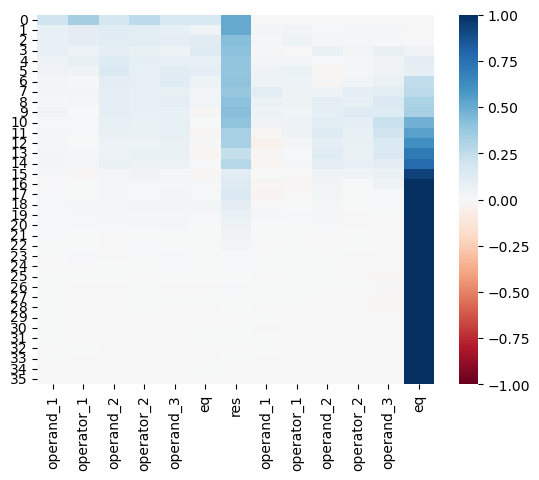

In [32]:
sns.heatmap(
        compute_macro_mean(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

<Axes: >

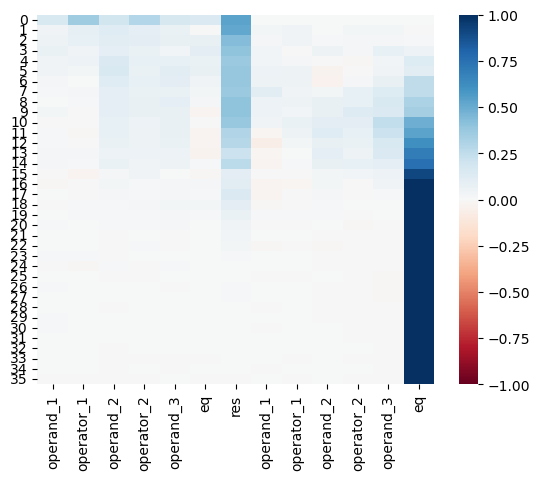

In [33]:
sns.heatmap(
        compute_micro_mean(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

In [34]:
torch.max(compute_pe(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs))

tensor(5.3958)

In [35]:
torch.min(compute_pe(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs))

tensor(-0.2340)

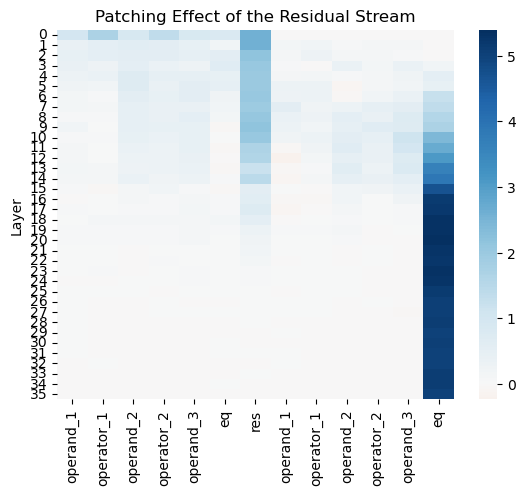

In [ ]:
sns.heatmap(
        compute_pe(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-0.2340,
        vmax=5.3958,
        yticklabels=True,
        annot=False,
        xticklabels = labels,
        center=0
    )

plt.title('Patching Effect of the Residual Stream')
plt.ylabel('Layer')
plt.show()

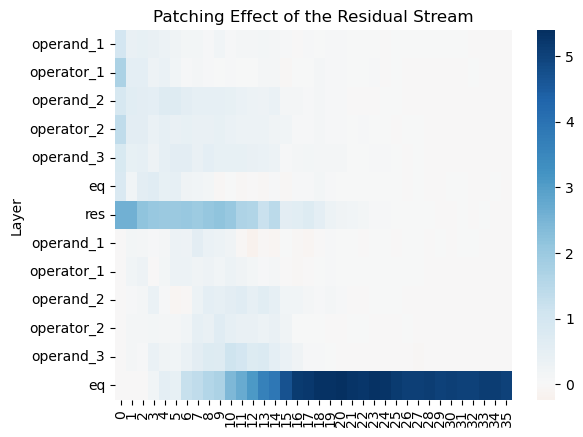

In [55]:
sns.heatmap(
        compute_pe(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs).T,
        cmap='RdBu',
        vmin=-0.2340,
        vmax=5.3958,
        yticklabels=labels,
        annot=False,
        xticklabels=True,
        center=0
    )

plt.title('Patching Effect of the Residual Stream')
plt.ylabel('Layer')
plt.show()

In [37]:
# attn_layer_act_patch_results = []
# attn_layer_clean_logit_diffs = []
# attn_layer_corrupted_logit_diffs = []
# for item in tqdm(corr_intervention_list):
#     patched_logit_diff, clean_logit_diff, corrupted_logit_diff = get_patched_result(item, activation_name='attn_layer')
#     attn_layer_act_patch_results.append(patched_logit_diff)
#     attn_layer_clean_logit_diffs.append(clean_logit_diff)
#     attn_layer_corrupted_logit_diffs.append(corrupted_logit_diff)

# attn_layer_patched_results_operands_operators = take_operands_and_operators_results(corr_intervention_list, attn_layer_act_patch_results)

In [38]:
# torch.save(attn_layer_act_patch_results, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_logit_diff_96_samples.pkl')
# torch.save(attn_layer_clean_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_clean_logit_diff_96_samples.pkl')
# torch.save(attn_layer_corrupted_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_corrupted_logit_diff_96_samples.pkl')

In [39]:
attn_layer_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_logit_diff_96_samples.pkl')
attn_layer_clean_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_clean_logit_diff_96_samples.pkl')
attn_layer_corrupted_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/attn_layer_corrupted_logit_diff_96_samples.pkl')

/tmp/ipykernel_4067906/2055145764.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_layer_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/d

In [40]:
attn_layer_patched_results_operands_operators = take_operands_and_operators_results(corr_intervention_list, attn_layer_act_patch_results)

<Axes: >

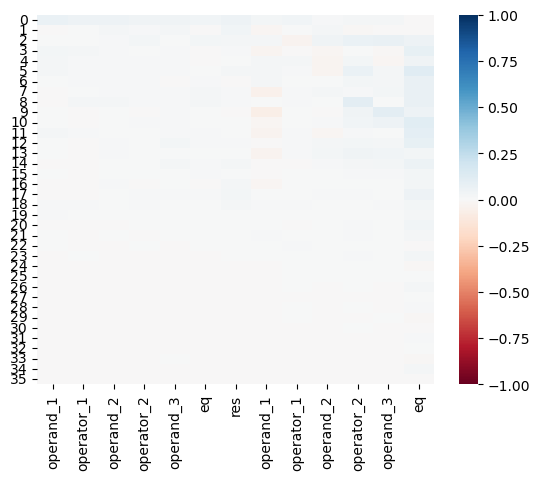

In [41]:
sns.heatmap(
        compute_macro_mean(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

<Axes: >

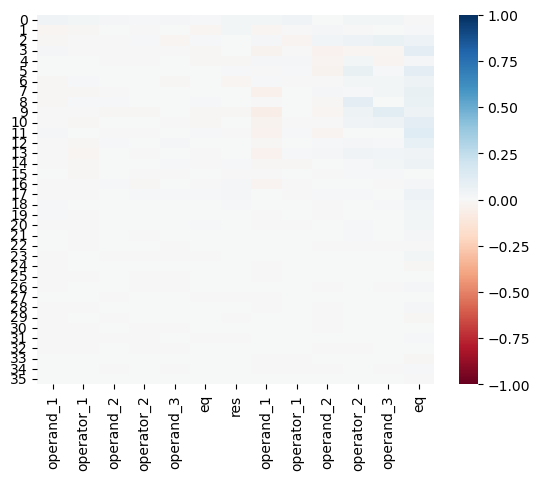

In [42]:
sns.heatmap(
        compute_micro_mean(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

In [43]:
torch.min(compute_pe(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs))

tensor(-0.3092)

In [44]:
torch.max(compute_pe(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs))

tensor(0.6315)

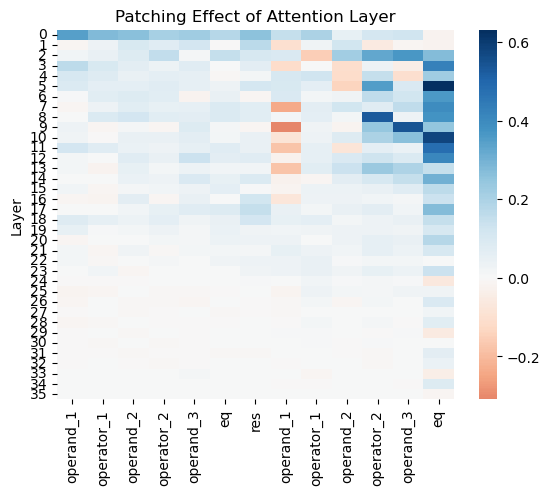

In [33]:
sns.heatmap(
    compute_pe(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs),
    cmap='RdBu',
    yticklabels=True,
    annot=False,
    xticklabels = labels,
    vmin=-0.3092,
    vmax=0.6315,
    center=0
)

plt.title('Patching Effect of Attention Layer')
plt.ylabel('Layer')
plt.show()

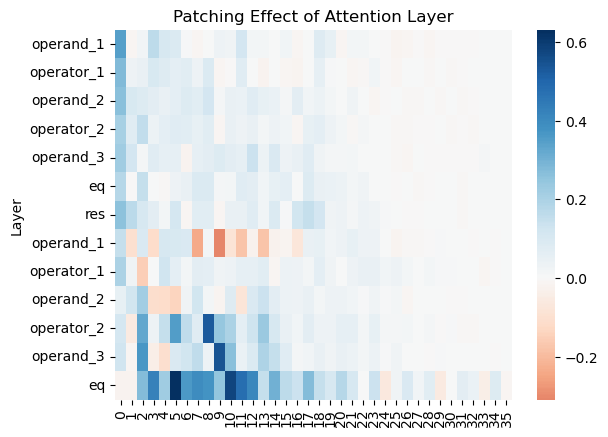

In [45]:
sns.heatmap(
    compute_pe(attn_layer_patched_results_operands_operators, attn_layer_clean_logit_diffs, attn_layer_corrupted_logit_diffs).T,
    cmap='RdBu',
    yticklabels=labels,
    annot=False,
    xticklabels=True,
    vmin=-0.3092,
    vmax=0.6315,
    center=0
)

plt.title('Patching Effect of Attention Layer')
plt.ylabel('Layer')
plt.show()

In [46]:
# mlp_act_patch_results = []
# mlp_clean_logit_diffs = []
# mlp_corrupted_logit_diffs = []
# for item in tqdm(corr_intervention_list):
#     patched_logit_diff, clean_logit_diff, corrupted_logit_diff = get_patched_result(item, activation_name='mlp')
#     mlp_act_patch_results.append(patched_logit_diff)
#     mlp_clean_logit_diffs.append(clean_logit_diff)
#     mlp_corrupted_logit_diffs.append(corrupted_logit_diff)

In [47]:
mlp_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/mlp_logit_diff_96_samples.pkl')
mlp_clean_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/mlp_clean_logit_diff_96_samples.pkl')
mlp_corrupted_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/mlp_corrupted_logit_diff_96_samples.pkl')

/tmp/ipykernel_4067906/111999855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_act_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patc

In [48]:
mlp_patched_results_operands_operators = take_operands_and_operators_results(corr_intervention_list, mlp_act_patch_results)

<Axes: >

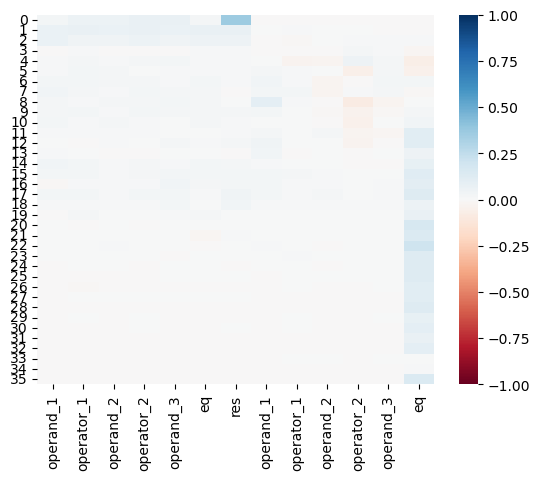

In [49]:
sns.heatmap(
        compute_macro_mean(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

<Axes: >

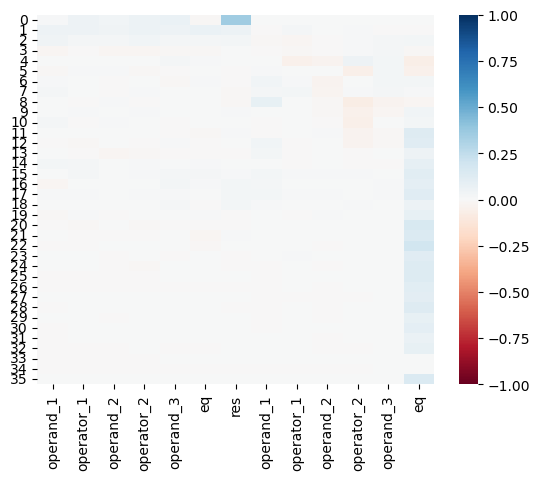

In [50]:
sns.heatmap(
        compute_micro_mean(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

In [51]:
torch.min(compute_pe(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs))

tensor(-0.4089)

In [52]:
torch.max(compute_pe(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs))

tensor(1.8398)

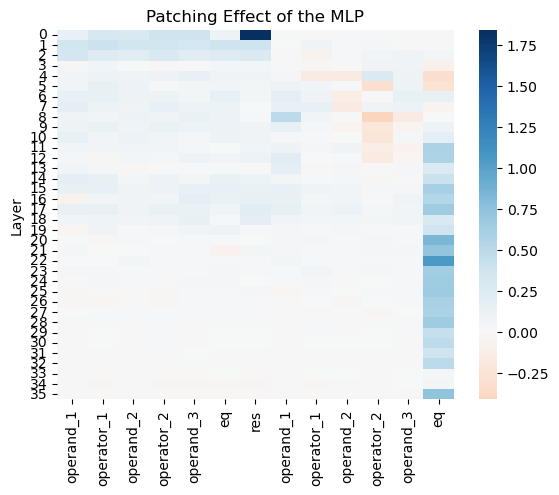

In [ ]:
sns.heatmap(
        compute_pe(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-0.4089,
        vmax=1.8398,
        center=0,
        yticklabels=True,
        annot=False,
        xticklabels = labels
    )

plt.title('Patching Effect of the MLP')
plt.ylabel('Layer')
plt.show()

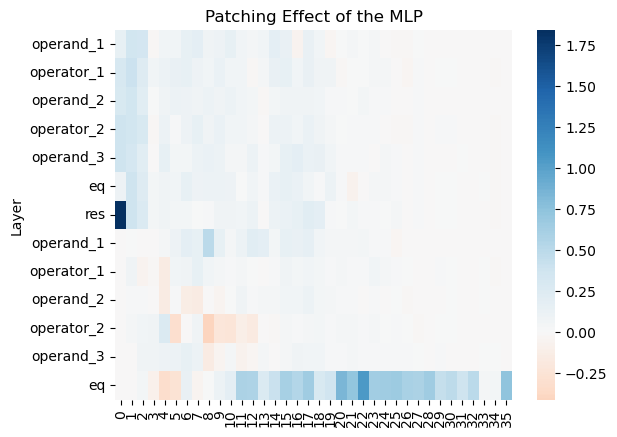

In [53]:
sns.heatmap(
        compute_pe(mlp_patched_results_operands_operators, mlp_clean_logit_diffs, mlp_corrupted_logit_diffs).T,
        cmap='RdBu',
        vmin=-0.4089,
        vmax=1.8398,
        center=0,
        yticklabels=labels,
        annot=False,
        xticklabels=True
    )

plt.title('Patching Effect of the MLP')
plt.ylabel('Layer')
plt.show()

Let's patch attention heads

In [77]:
# head_patch_results = []
# head_clean_logit_diffs = []
# head_corrupted_logit_diffs = []
# for item in tqdm(corr_intervention_list):
#     patched_logit_diff, clean_logit_diff, corrupted_logit_diff = get_patched_result(item, activation_name='head')
#     head_patch_results.append(patched_logit_diff)
#     head_clean_logit_diffs.append(clean_logit_diff)
#     head_corrupted_logit_diffs.append(corrupted_logit_diff)

In [78]:
# torch.save(head_patch_results, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_patch_logit_diff_96_samples.pkl')
# torch.save(head_clean_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_clean_logit_diff_96_samples.pkl')
# torch.save(head_corrupted_logit_diffs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_clean_corrupted_diff_96_samples.pkl')

In [79]:
head_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_patch_logit_diff_96_samples.pkl')
head_clean_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_clean_logit_diff_96_samples.pkl')
head_corrupted_logit_diffs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_pythia_12b/head_clean_corrupted_diff_96_samples.pkl')

/tmp/ipykernel_1393605/2746894999.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  head_patch_results = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patchi

<Axes: >

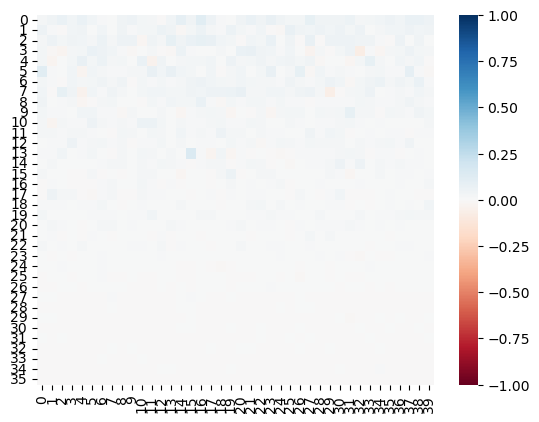

In [80]:
sns.heatmap(
        compute_macro_mean(head_patch_results, head_clean_logit_diffs, head_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = True
    )

<Axes: >

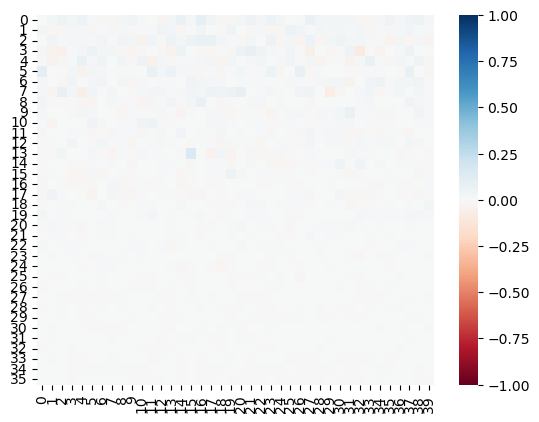

In [81]:
sns.heatmap(
        compute_micro_mean(head_patch_results, head_clean_logit_diffs, head_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        yticklabels=True,
        annot=False,
        xticklabels = True
    )

In [82]:
torch.min(compute_pe(head_patch_results, head_clean_logit_diffs, head_corrupted_logit_diffs))

tensor(-0.3835)

In [83]:
torch.max(compute_pe(head_patch_results, head_clean_logit_diffs, head_corrupted_logit_diffs))

tensor(0.7194)

<Axes: >

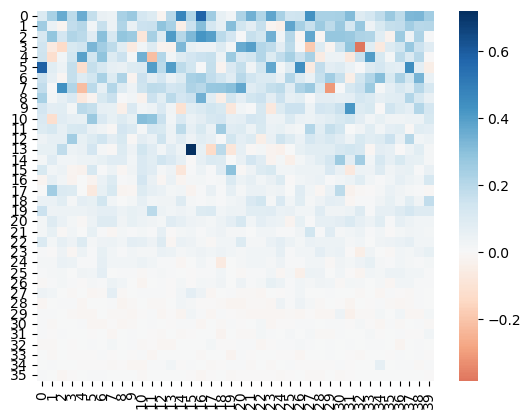

In [85]:
sns.heatmap(
        compute_pe(head_patch_results, head_clean_logit_diffs, head_corrupted_logit_diffs),
        cmap='RdBu',
        vmin=-0.3835,
        vmax=0.7194,
        center=0,
        yticklabels=True,
        annot=False,
        xticklabels = True
    )